In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
from training_utils import iterative_pruning
from training_utils import initializer

Set Seeds

In [6]:
import tensorflow as tf

In [7]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
import matplotlib

In [9]:
np.where(np.linspace(-0.3,0.3,1001) == 0)

(array([500]),)

In [10]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.3,0.3,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### Tensorflow

In [11]:
import tensorflow as tf
#import tensorflow_probability as tfp
from tensorflow.keras import layers

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [12]:
import tensorflow_datasets as tfds

In [13]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [13]:
#with tf.device('/CPU:0'):
(ds_train_cif10, ds_test_cif10), ds_info_cif10 = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [14]:
#@tf.function
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label,10)

#@tf.function
def prep_data(ds, ds_info):
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(256)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds
#ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
#ds_train = ds_train.batch(128)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_test = ds_test.cache()

#ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
#ds_test = ds_test.batch(128)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
ds_train_mnist = prep_data(ds_train_mnist, ds_info_mnist)
ds_test_mnist = prep_data(ds_test_mnist, ds_info_mnist)

In [17]:
tf.math.reduce_std(iter(ds_train_mnist).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.30830413>

In [18]:
tf.math.reduce_mean(iter(ds_train_mnist).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.13256954>

In [15]:
#with tf.device('/CPU:0'):
ds_train_cif10 = prep_data(ds_train_cif10, ds_info_cif10)
ds_test_cif10 = prep_data(ds_test_cif10, ds_info_cif10)

In [16]:
tf.math.reduce_std(iter(ds_train_cif10).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.25192398>

In [17]:
tf.math.reduce_mean(iter(ds_train_cif10).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.46676275>

# CNN

[(W−K+2P)/S]+1

In [18]:
init = initializer()

initializer


In [19]:
from custom_nn import MaskedConv2D, MaxPool2DExt, Conv2_Mask, Conv4_Mask

In [20]:
from custom_nn import Dense_Mask

In [21]:
INPUT_SHAPE = iter(ds_train_cif10).next()[0].numpy().shape
SIGMOID_MULTIPLIER = [.1,.1,.2,.2,.2]

In [22]:
INPUT_SHAPE = (128, 32, 32, 3)
SIGMOID_MULTIPLIER = [.2,.2,.2, 0.2, 0.2 ,.17,.13]

In [144]:
class ModelTrainer():
    def __init__(self, model, ds_train, ds_test, lr=0.1):
        self.model = model
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        
        self.ds_train = ds_train
        self.ds_test = ds_test
        
        self.mask_history = []
        self.loss_history = []
        self.acc_history = []
        
        self.loss_metric = tf.keras.metrics.Mean()
        self.acc_metric = tf.keras.metrics.CategoricalAccuracy()
        
    @tf.function
    def train_step(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            predicted = self.model(x_batch, training=True)
            loss = self.loss_fn(y_batch, predicted)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss, predicted
    
    @tf.function
    def calc_ones_ratio(self):
        global_no_ones = tf.reduce_sum([tf.reduce_sum(layer.get_bernoulli_mask()) for layer in self.model.layers if layer.type == "fefo" or layer.type == "conv"])
        global_size = tf.reduce_sum([tf.size(layer.get_bernoulli_mask()) for layer in self.model.layers if layer.type == "fefo" or layer.type == "conv"])
        
        #tf.print(global_no_ones)
        #tf.print(global_size)

        #remaining_ones_ratio = (tf.cast(global_no_ones, tf.float32)/tf.cast(global_size, tf.float32))*100.0
        #tf.print(remaining_ones_ratio)
        #tf.print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
    
    def train(self, epochs, supermask=True):
        if supermask is True:
            for epoch in range(epochs):
                for step, (x_batch_train, y_batch_train) in enumerate(self.ds_train):
                    loss, predicted = self.train_step(x_batch_train, y_batch_train)

                    self.loss_metric(loss)
                    self.acc_metric(y_batch_train,predicted)

                self.mask_history.append([layer.bernoulli_mask for layer in self.model.layers if layer.type is "conv" or layer.type is "fefo"])
                self.loss_history.append(self.loss_metric.result().numpy())
                self.acc_history.append(self.acc_metric.result().numpy())

                print(f"End of Epoch: {epoch+1}: Accuracy = {self.acc_metric.result().numpy():.6f} --- Mean Loss = {self.loss_metric.result().numpy():.6f}")
                
                self.loss_metric.reset_states()
                self.acc_metric.reset_states()
                
                tf.py_function(self.calc_ones_ratio, inp=[], Tout=[])

        else:
            for epoch in range(epochs):
                for step, (x_batch_train, y_batch_train) in enumerate(self.ds_train):
                    loss, predicted = self.train_step(x_batch_train, y_batch_train)

                    self.loss_metric(loss)
                    self.acc_metric(y_batch_train,predicted)

                self.loss_history.append(self.loss_metric.result().numpy())
                self.acc_history.append(self.acc_metric.result().numpy())

                print(f"End of Epoch: {epoch+1}: Accuracy = {self.acc_metric.result().numpy():.6f} --- Mean Loss = {self.loss_metric.result().numpy():.6f}")
            
            
    def evaluate(self):
        eval_acc = tf.keras.metrics.CategoricalAccuracy()
        eval_loss_mean = tf.keras.metrics.Mean()
        loss_fn = tf.keras.losses.CategoricalCrossentropy()
        for x_batch_test, y_batch_test in self.ds_test:
            eval_pred = self.model(x_batch_test)
            eval_loss = loss_fn(y_batch_test, eval_pred)

            eval_loss_mean(eval_loss)
            eval_acc(y_batch_test, eval_pred)

        print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
        print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

## Baseline

In [25]:
from custom_nn import Conv2

In [26]:
conv2 = Conv2()

In [27]:
mt = ModelTrainer(conv2, ds_train_cif10, ds_test_cif10, lr=0.01)
mt.train(300, supermask=False)

End of Epoch: 1: Accuracy = 0.302380 --- Mean Loss = 1.919293
End of Epoch: 2: Accuracy = 0.388470 --- Mean Loss = 1.695062


KeyboardInterrupt: 

In [33]:
mt.evaluate()

Evaluation Loss: 2.8473868370056152
Evaluation Accuracy: 0.6890000104904175


In [25]:
def just_train(model, ds_train, epochs=6):
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    #gradient_history = []
    #layerwise_output_all = []
    
    for epoch in range(epochs):
    
        #print(f"Start of epoch {epoch}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted = model(x_batch_train)
                #layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)


            grads = tape.gradient(loss, model.trainable_weights)
            #gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)
            acc_metric(y_batch_train,predicted)
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())

        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
    
    return loss_history, acc_history #, layerwise_output_all, gradient_history #model, 

In [26]:
loss_history, acc_history = just_train(conv2, ds_train_cif10, epochs=100)

End of Epoch: 1: Accuracy = 0.303820 --- Mean Loss = 1.921454
End of Epoch: 2: Accuracy = 0.389570 --- Mean Loss = 1.695626
End of Epoch: 3: Accuracy = 0.444400 --- Mean Loss = 1.547894
End of Epoch: 4: Accuracy = 0.486690 --- Mean Loss = 1.435736
End of Epoch: 5: Accuracy = 0.519668 --- Mean Loss = 1.344660
End of Epoch: 6: Accuracy = 0.548957 --- Mean Loss = 1.265655
End of Epoch: 7: Accuracy = 0.574726 --- Mean Loss = 1.195560
End of Epoch: 8: Accuracy = 0.598517 --- Mean Loss = 1.130238
End of Epoch: 9: Accuracy = 0.620560 --- Mean Loss = 1.069263
End of Epoch: 10: Accuracy = 0.641988 --- Mean Loss = 1.009829
End of Epoch: 11: Accuracy = 0.662600 --- Mean Loss = 0.952758
End of Epoch: 12: Accuracy = 0.682140 --- Mean Loss = 0.898449
End of Epoch: 13: Accuracy = 0.700815 --- Mean Loss = 0.846662
End of Epoch: 14: Accuracy = 0.718286 --- Mean Loss = 0.797858
End of Epoch: 15: Accuracy = 0.734436 --- Mean Loss = 0.752905
End of Epoch: 16: Accuracy = 0.748755 --- Mean Loss = 0.712894
E

KeyboardInterrupt: 

In [206]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
conv2, initial_weights = init.set_weights_man(conv2, mode="uniform", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False)

AttributeError: 'Conv2DExt' object has no attribute 'weight_shape'

In [80]:
o = tf.Variable(np.random.randint(0,2, size=(3,3,3,64)))
o.shape

TensorShape([3, 3, 3, 64])

In [70]:
tf.size(o[:,:,:,0])

<tf.Tensor: shape=(), dtype=int32, numpy=27>

In [82]:
tf.size(o.shape[:-1])

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [104]:
single_filter_size = tf.reduce_prod(o.shape[:-1])
single_filter_size

<tf.Tensor: shape=(), dtype=int32, numpy=27>

In [90]:
m = tf.reduce_sum(tf.reshape(o ,(single_filter_size,o.shape[-1])),axis=0)

In [93]:
o[:,:,:,0]

<tf.Tensor: shape=(3, 3, 3), dtype=int64, numpy=
array([[[1, 0, 1],
        [0, 0, 1],
        [1, 0, 0]],

       [[1, 1, 1],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 1, 0],
        [1, 0, 0],
        [1, 1, 1]]])>

In [107]:
tf.cast(m, tf.float32)

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([15., 15., 15., 14., 12., 11., 14.,  7., 15., 12., 14., 12., 13.,
       12., 15., 13., 15., 16., 18., 17., 12., 17., 14., 11., 16., 19.,
       15., 15., 18., 17., 14., 10., 17., 15., 10., 15., 13., 16., 13.,
       18., 15., 15., 18., 13., 11., 16., 16., 13., 15., 15., 10., 12.,
       12., 12., 15., 15., 12., 15., 15., 14., 13., 12.,  8., 14.],
      dtype=float32)>

In [108]:
27/15

1.8

In [106]:
tf.cast(single_filter_size, tf.float32) / tf.cast(m, tf.float32)

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([1.8      , 1.8      , 1.8      , 1.9285715, 2.25     , 2.4545455,
       1.9285715, 3.857143 , 1.8      , 2.25     , 1.9285715, 2.25     ,
       2.0769231, 2.25     , 1.8      , 2.0769231, 1.8      , 1.6875   ,
       1.5      , 1.5882353, 2.25     , 1.5882353, 1.9285715, 2.4545455,
       1.6875   , 1.4210526, 1.8      , 1.8      , 1.5      , 1.5882353,
       1.9285715, 2.7      , 1.5882353, 1.8      , 2.7      , 1.8      ,
       2.0769231, 1.6875   , 2.0769231, 1.5      , 1.8      , 1.8      ,
       1.5      , 2.0769231, 2.4545455, 1.6875   , 1.6875   , 2.0769231,
       1.8      , 1.8      , 2.7      , 2.25     , 2.25     , 2.25     ,
       1.8      , 1.8      , 2.25     , 1.8      , 1.8      , 1.9285715,
       2.0769231, 2.25     , 3.375    , 1.9285715], dtype=float32)>

In [95]:
m[0]

<tf.Tensor: shape=(), dtype=int64, numpy=15>

In [101]:
%timeit a = tf.multiply(o,m)#o*m
a.shape

14.6 µs ± 469 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


TensorShape([3, 3, 3, 64])

In [102]:
%timeit a = o*m

28 µs ± 835 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [100]:
a[:,:,:,0]

<tf.Tensor: shape=(3, 3, 3), dtype=int64, numpy=
array([[[15,  0, 15],
        [ 0,  0, 15],
        [15,  0,  0]],

       [[15, 15, 15],
        [15,  0,  0],
        [15,  0,  0]],

       [[15, 15,  0],
        [15,  0,  0],
        [15, 15, 15]]])>

# Masked

In [67]:
from custom_nn import Conv2_Mask

In [68]:
INPUT_SHAPE = (128, 32, 32, 3)
SIGMOID_MULTIPLIER = [.25,.23,.21,.17,.13] #[1.,1.,1.,1.,1.]#

In [92]:
conv2_mask = Conv2_Mask(input_shape=INPUT_SHAPE, sigmoid_multiplier=SIGMOID_MULTIPLIER, use_dropout=False, 
                        dynamic_scaling_cnn=False, dynamic_scaling_dense=True)

In [93]:
conv2_mask(iter(ds_train_cif10).next()[0])

<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
array([[1.5092505e-08, 8.8514285e-10, 3.0532408e-07, ..., 1.6881269e-17,
        1.6698372e-03, 5.4538934e-10],
       [1.5980743e-10, 1.4792583e-07, 4.0656698e-13, ..., 8.6208755e-24,
        9.3793785e-03, 1.2763675e-14],
       [2.0634772e-13, 4.0062679e-07, 3.5291617e-11, ..., 5.5055675e-24,
        6.5672666e-02, 2.4361283e-13],
       ...,
       [2.2730651e-16, 1.0731255e-10, 7.3738134e-12, ..., 4.8680212e-24,
        1.2967047e-01, 1.0294142e-13],
       [4.1080359e-08, 6.9072210e-09, 6.4082779e-03, ..., 4.2808181e-15,
        1.5232603e-08, 4.3405268e-14],
       [2.6522443e-07, 5.5237811e-06, 3.2757379e-16, ..., 3.2731221e-19,
        1.4737761e-04, 3.3165115e-10]], dtype=float32)>

In [94]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
conv2_mask, initial_weights = init.set_weights_man(conv2_mask, mode="signed_constant", constant=-2, mu=MU, sigma=-4, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True, set_mask=False) # uniform -3
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)_mas

Signed constant (std): 0.6666666666666666
Signed constant (std): 0.6666666666666666
Signed constant (std): 0.000744047619047619
Signed constant (std): 0.0078125
Signed constant (std): 0.0078125


In [95]:
conv2_mask, initial_weights = init.set_weights_man(conv2_mask, mode="uniform", constant=1, mu=MU, sigma=-1, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)

Glorot uniform with bound 0.0274
Glorot uniform with bound 0.0149
Glorot uniform with bound 0.0007
Glorot uniform with bound 0.0039
Glorot uniform with bound 0.0075


In [96]:
for layer in conv2_mask.layers:
    if layer.type == "fefo":
        print("Feed Forward with shape: ", layer.shape)
    if layer.type == "conv":
        print("Convolutional Layer with weight shape: ", layer.weight_shape)
    else:
        continue
        

Convolutional Layer with weight shape:  (3, 3, 3, 64)
Convolutional Layer with weight shape:  (3, 3, 64, 64)
Feed Forward with shape:  (2688, 256)
Feed Forward with shape:  (256, 256)
Feed Forward with shape:  (256, 10)


In [97]:
import gc
gc.collect()

142

In [141]:
def just_eval(model, ds_test):
    eval_acc = tf.keras.metrics.CategoricalAccuracy()
    eval_loss_mean = tf.keras.metrics.Mean()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    for x_batch_test, y_batch_test in ds_test:
        eval_pred = model(x_batch_test)
        eval_loss = loss_fn(y_batch_test, eval_pred)

        eval_loss_mean(eval_loss)
        eval_acc(y_batch_test, eval_pred)

    print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
    print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

In [145]:
r_schedule = tf.keras.optimizers.schedules.ExponentialDecay(10., decay_steps=100000, decay_rate=0.99, staircase=True)
mt = ModelTrainer(conv2_mask, lr=.04, ds_train = ds_train_cif10, ds_test = ds_test_cif10)

In [146]:
mt.train(epochs=200)

End of Epoch: 1: Accuracy = 0.625720 --- Mean Loss = 1.066760


InvalidArgumentError: TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: conv2__mask_4/conv_in/SelectV2_1:0
Traceback (most recent call last):

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 241, in __call__
    return func(device, token, args)

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 130, in __call__
    ret = self._func(*args)

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 309, in wrapper
    return func(*args, **kwargs)

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 580, in __call__
    result = self._call(*args, **kwds)

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 650, in _call
    return self._concrete_stateful_fn._filtered_call(canon_args, canon_kwds)  # pylint: disable=protected-access

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 1665, in _filtered_call
    self.captured_inputs)

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 1746, in _call_flat
    ctx, args, cancellation_manager=cancellation_manager))

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 598, in call
    ctx=ctx)

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/execute.py", line 75, in quick_execute
    raise e

  File "/home/nils/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/execute.py", line 60, in quick_execute
    inputs, attrs, num_outputs)

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: conv2__mask_4/conv_in/SelectV2_1:0

 [Op:EagerPyFunc]

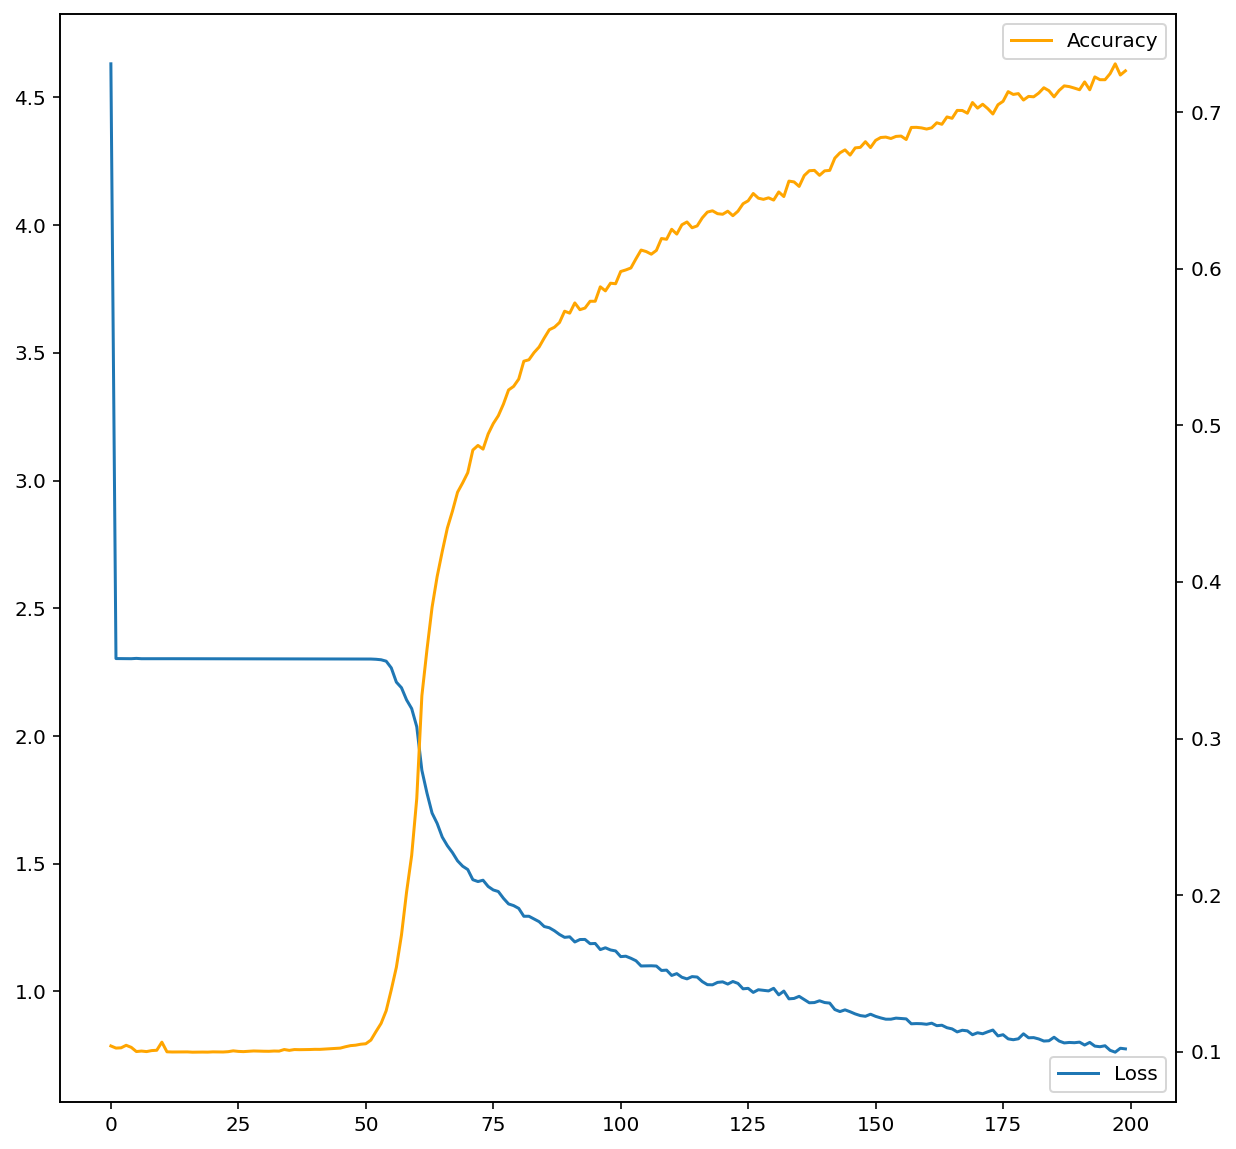

In [153]:
plt.plot(mt.loss_history, label="Loss")
plt.legend(loc=4)
plt.twinx()
plt.plot(mt.acc_history, c="orange", label="Accuracy")
plt.legend(loc=1)

In [154]:
mt.evaluate()

Evaluation Loss: 1.438698172569275
Evaluation Accuracy: 0.5472999811172485


# What causes overfitting?
- dynamic scaling
- sigmoid multiplier

In [145]:
mt.mask_history

[[<tf.Tensor: shape=(3, 3, 3, 64), dtype=float32, numpy=
  array([[[[0., 0., 0., ..., 1., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 1., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]],
  
  
         [[[0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 1., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]],
  
  
         [[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
  
          [[0., 1., 0., .

In [125]:
#@tf.function
def train_supermask_model(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr1 = 1.
    #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr1, decay_steps=100000, decay_rate=0.99, staircase=True)

    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1, momentum=0.9)
    
    #loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    remaining_ones_ratio_history = []
    
    #with tf.device('/CPU:0'):
    layerwise_output_all = []
    gradient_history = []
    mask_history = []
    
    mt = ModelTrainer(model, lr=lr1)
    
    epoch_half = epochs // 2
    epoch_quarter = epoch_half // 2
    
    for epoch in range(epochs):
        
        #if epoch == epoch_half:
        #    mt.update_lr(lr1/2)
            #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1/2, momentum=0.9)
        #elif epoch == (epoch_half+epoch_quarter):
        #    mt.update_lr(lr1/4)
            #optimizer = tf.keras.optimizers.SGD(learning_rate=lr1/4, momentum=0.9)
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
#            with tf.GradientTape() as tape:
#                predicted, layerwise_output = model(x_batch_train, training=True) #, epoch
#                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
#                loss = loss_fn(y_batch_train, predicted)

 #           grads = tape.gradient(loss, model.trainable_weights)
            #print(grads)
            #print("gradient mean", tf.reduce_mean(grads))
            #gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            #mask_weights = [var for var in model.trainable_weights if "kernel" not in var.name]
#            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            loss, predicted = mt.train_step(x_batch_train, y_batch_train)

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
        
        #gc.collect()
        
        #with tf.device('/CPU:0'):
        #print(model.layers[0].mask)
        model
        
        mask_history.append([layer.bernoulli_mask for layer in model.layers if layer.type is "conv" or layer.type is "fefo"])
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        #save the last gradient of each epoch
        #gradient_history.append(grads)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        
        
        #if epoch % 20 == 0:
        #    global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in model.layers if layer.type == "fefo" or layer.type == "conv"])
        #    global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in model.layers if layer.type == "fefo" or layer.type == "conv"])

        #    remaining_ones_ratio = (global_no_ones/global_size)*100
        #    print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
            #remaining_ones_ratio_history.append(remaining_ones_ratio)

    return model, loss_history, acc_history, mask_history #, layerwise_output_all, gradient_history, remaining_ones_ratio_history, mask_history

https://github.com/tensorflow/tensorflow/issues/32707  
https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [77]:
len(conv2_mask.trainable_weights)

5

In [78]:
for w in conv2_mask.trainable_weights:
    print(w.name, w.shape)

mask:0 (3, 3, 3, 64)
mask:0 (3, 3, 64, 64)
mask:0 (2688, 256)
mask:0 (256, 256)
mask:0 (256, 10)


In [79]:
for w in conv2_mask.non_trainable_weights:
    print(w.name, w.shape)

bias:0 (64,)
weights:0 (3, 3, 3, 64)
bias:0 (64,)
weights:0 (3, 3, 64, 64)
b:0 (256,)
w:0 (2688, 256)
b:0 (256,)
w:0 (256, 256)
b:0 (10,)
w:0 (256, 10)


In [129]:
conv2_mask, loss_history_mask, acc_history_mask, mask_history = train_supermask_model(conv2_mask, ds_train_cif10, epochs=10) #, layerwise_output_all, gradient_history, ones_ratio_history, mask_history

End of Epoch: 1: Accuracy = 0.112920 --- Mean Loss = 2.302460
End of Epoch: 2: Accuracy = 0.114810 --- Mean Loss = 2.302450
End of Epoch: 3: Accuracy = 0.115960 --- Mean Loss = 2.302440
End of Epoch: 4: Accuracy = 0.116010 --- Mean Loss = 2.302427
End of Epoch: 5: Accuracy = 0.117112 --- Mean Loss = 2.302414
End of Epoch: 6: Accuracy = 0.118460 --- Mean Loss = 2.302399
End of Epoch: 7: Accuracy = 0.119283 --- Mean Loss = 2.302383
End of Epoch: 8: Accuracy = 0.120158 --- Mean Loss = 2.302365
End of Epoch: 9: Accuracy = 0.120864 --- Mean Loss = 2.302346
End of Epoch: 10: Accuracy = 0.121472 --- Mean Loss = 2.302332


In [131]:
conv2_mask

In [163]:
mt.model.layers[0].bernoulli_mask

<tf.Tensor: shape=(3, 3, 3, 64), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 1., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
       

In [94]:
for layer in conv2_mask.layers:
    print(layer.type)
    if layer.type == "conv" or layer.type == "fefo":
        print(layer.bernoulli_mask)

conv
tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 1. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 1. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 1. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]], shape=(3, 3, 3, 64), dtype=float32)
conv
tf.Tensor(
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0

In [155]:
global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in mt.model.layers if layer.type == "fefo" or layer.type == "conv"])
global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in mt.model.layers if layer.type == "fefo" or layer.type == "conv"])

remaining_ones_ratio = (global_no_ones/global_size)*100
print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")

49.09% of weights are 'remaining'


In [156]:
just_eval(mt.model, ds_test_cif10)

Evaluation Loss: 1.42228102684021
Evaluation Accuracy: 0.5472999811172485


In [213]:
import seaborn as sns

In [222]:
tf.nn.bias_add(tf.Variable([[3,2],[0,2]]), tf.constant([1,1]))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[4, 3],
       [1, 3]], dtype=int32)>

In [230]:
x = tf.Variable(np.random.randint(0,5,size=(10,1)))
x

<tf.Variable 'Variable:0' shape=(10, 1) dtype=int64, numpy=
array([[1],
       [3],
       [2],
       [0],
       [0],
       [3],
       [4],
       [0],
       [3],
       [2]])>

In [246]:
o = tf.Variable(1, dtype="int64")
o

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=1>

In [249]:
tf.concat([x,o], axis=-1)

InvalidArgumentError: ConcatOp : Ranks of all input tensors should match: shape[0] = [10,1] vs. shape[1] = [] [Op:ConcatV2] name: concat

In [231]:
w = tf.Variable(np.random.randint(0,5, size=(10,2)))
w

<tf.Variable 'Variable:0' shape=(10, 2) dtype=int64, numpy=
array([[4, 1],
       [2, 3],
       [3, 0],
       [0, 3],
       [2, 2],
       [4, 0],
       [1, 4],
       [1, 3],
       [1, 2],
       [2, 3]])>

In [234]:
tf.matmul(x,w, transpose_a=True)

<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[39, 38]])>

In [216]:
mt.model.layers[4].shape

(2688, 256)

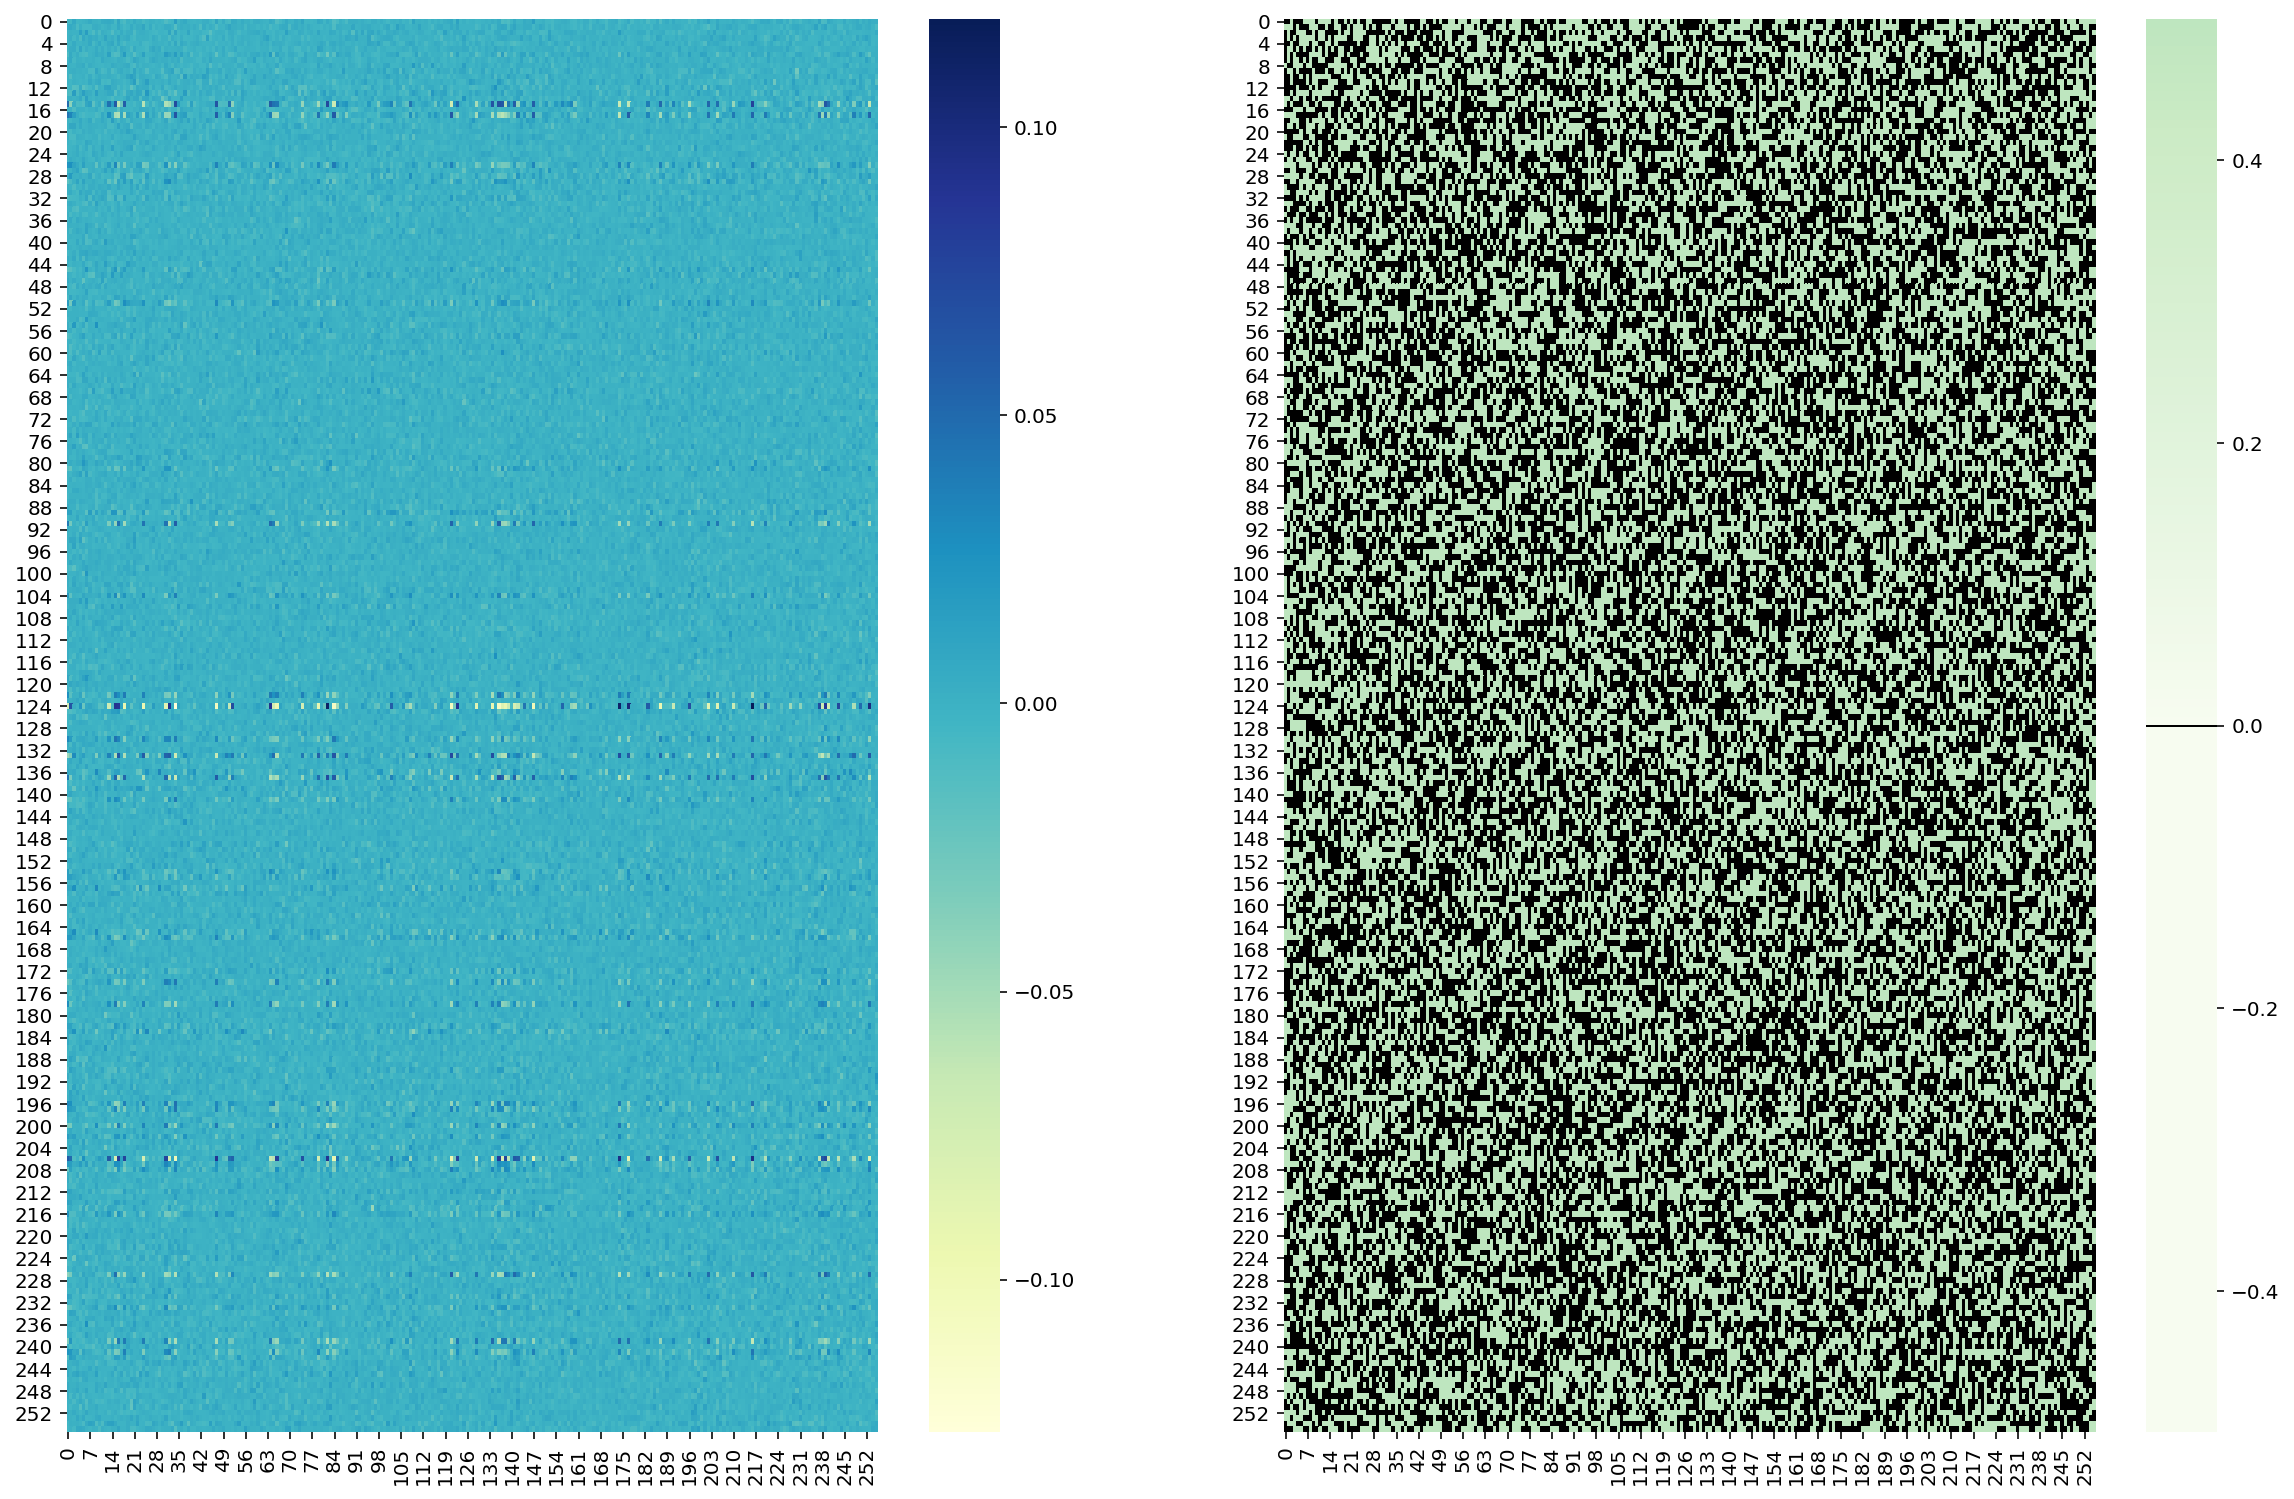

In [157]:
layer = 5
plt.figure(figsize=(20,13))
plt.subplot(1,2,1)
sns.heatmap(mt.model.layers[layer].mask.numpy(),cbar=True, cmap="YlGnBu")
plt.subplot(1,2,2)
sns.heatmap(mt.model.layers[layer].bernoulli_mask.numpy(),cmap=cmap, vmin=-0.5, vmax=0.5)

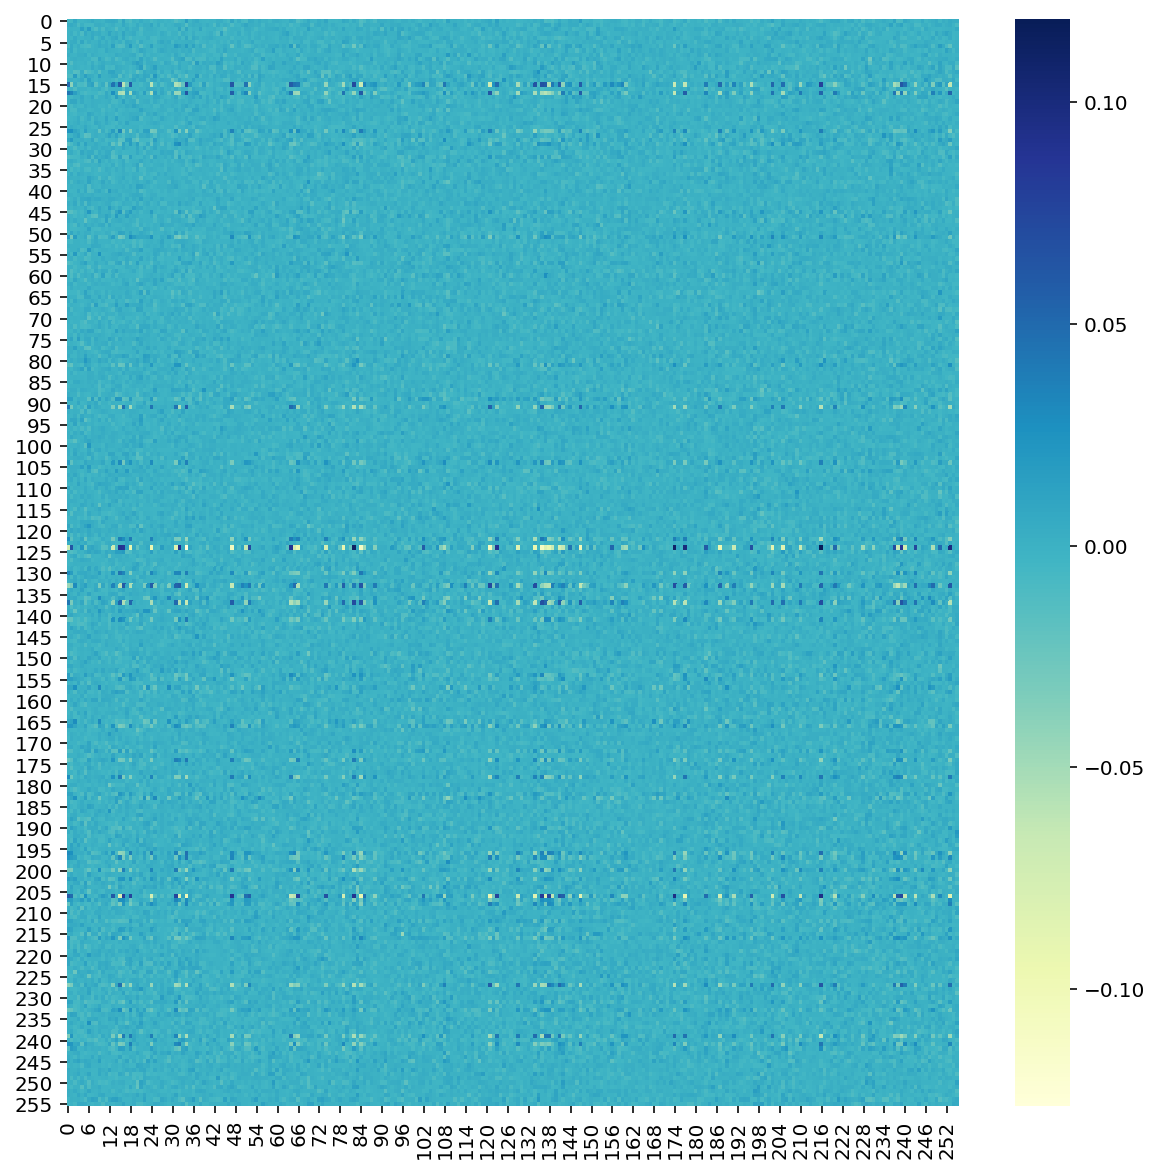

In [158]:
sns.heatmap(conv2_mask.layers[5].mask.numpy(),cbar=True, cmap="YlGnBu")

In [52]:
INPUT_SHAPE[0:]

(128, 32, 32, 3)

In [159]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE[1:], batch_size=256))
model.add(conv2_mask.layers[0])
#model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [160]:
test_img = iter(ds_train_cif10).next()[0][0]

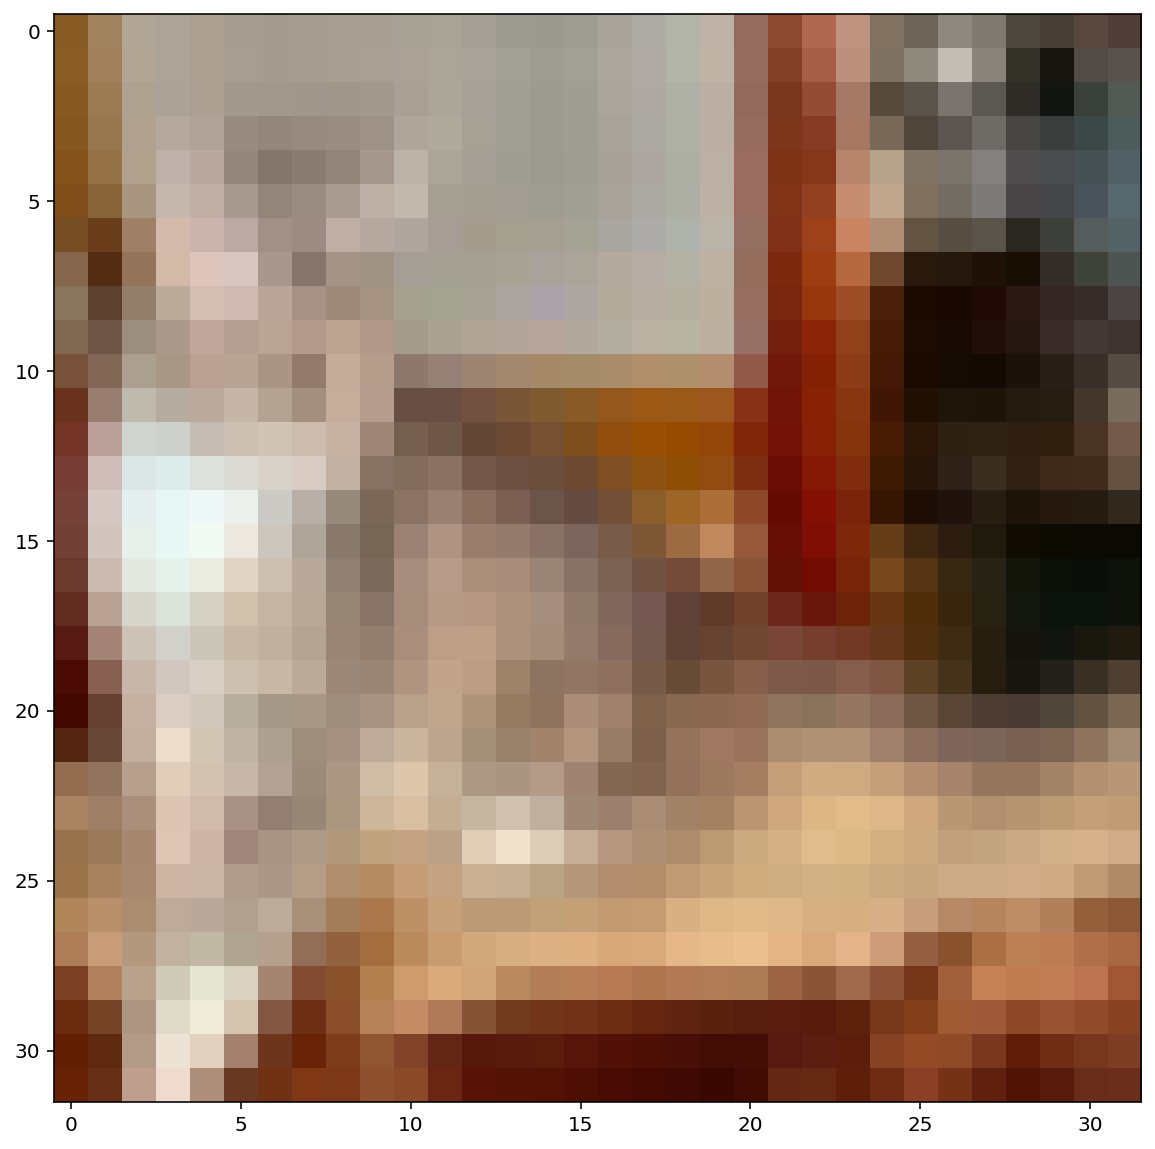

In [161]:
plt.imshow(test_img)

In [162]:
test = model(tf.expand_dims(test_img, axis=0))

In [163]:
test0 = test[0].numpy()

In [58]:
test0.shape

(30, 15, 64)

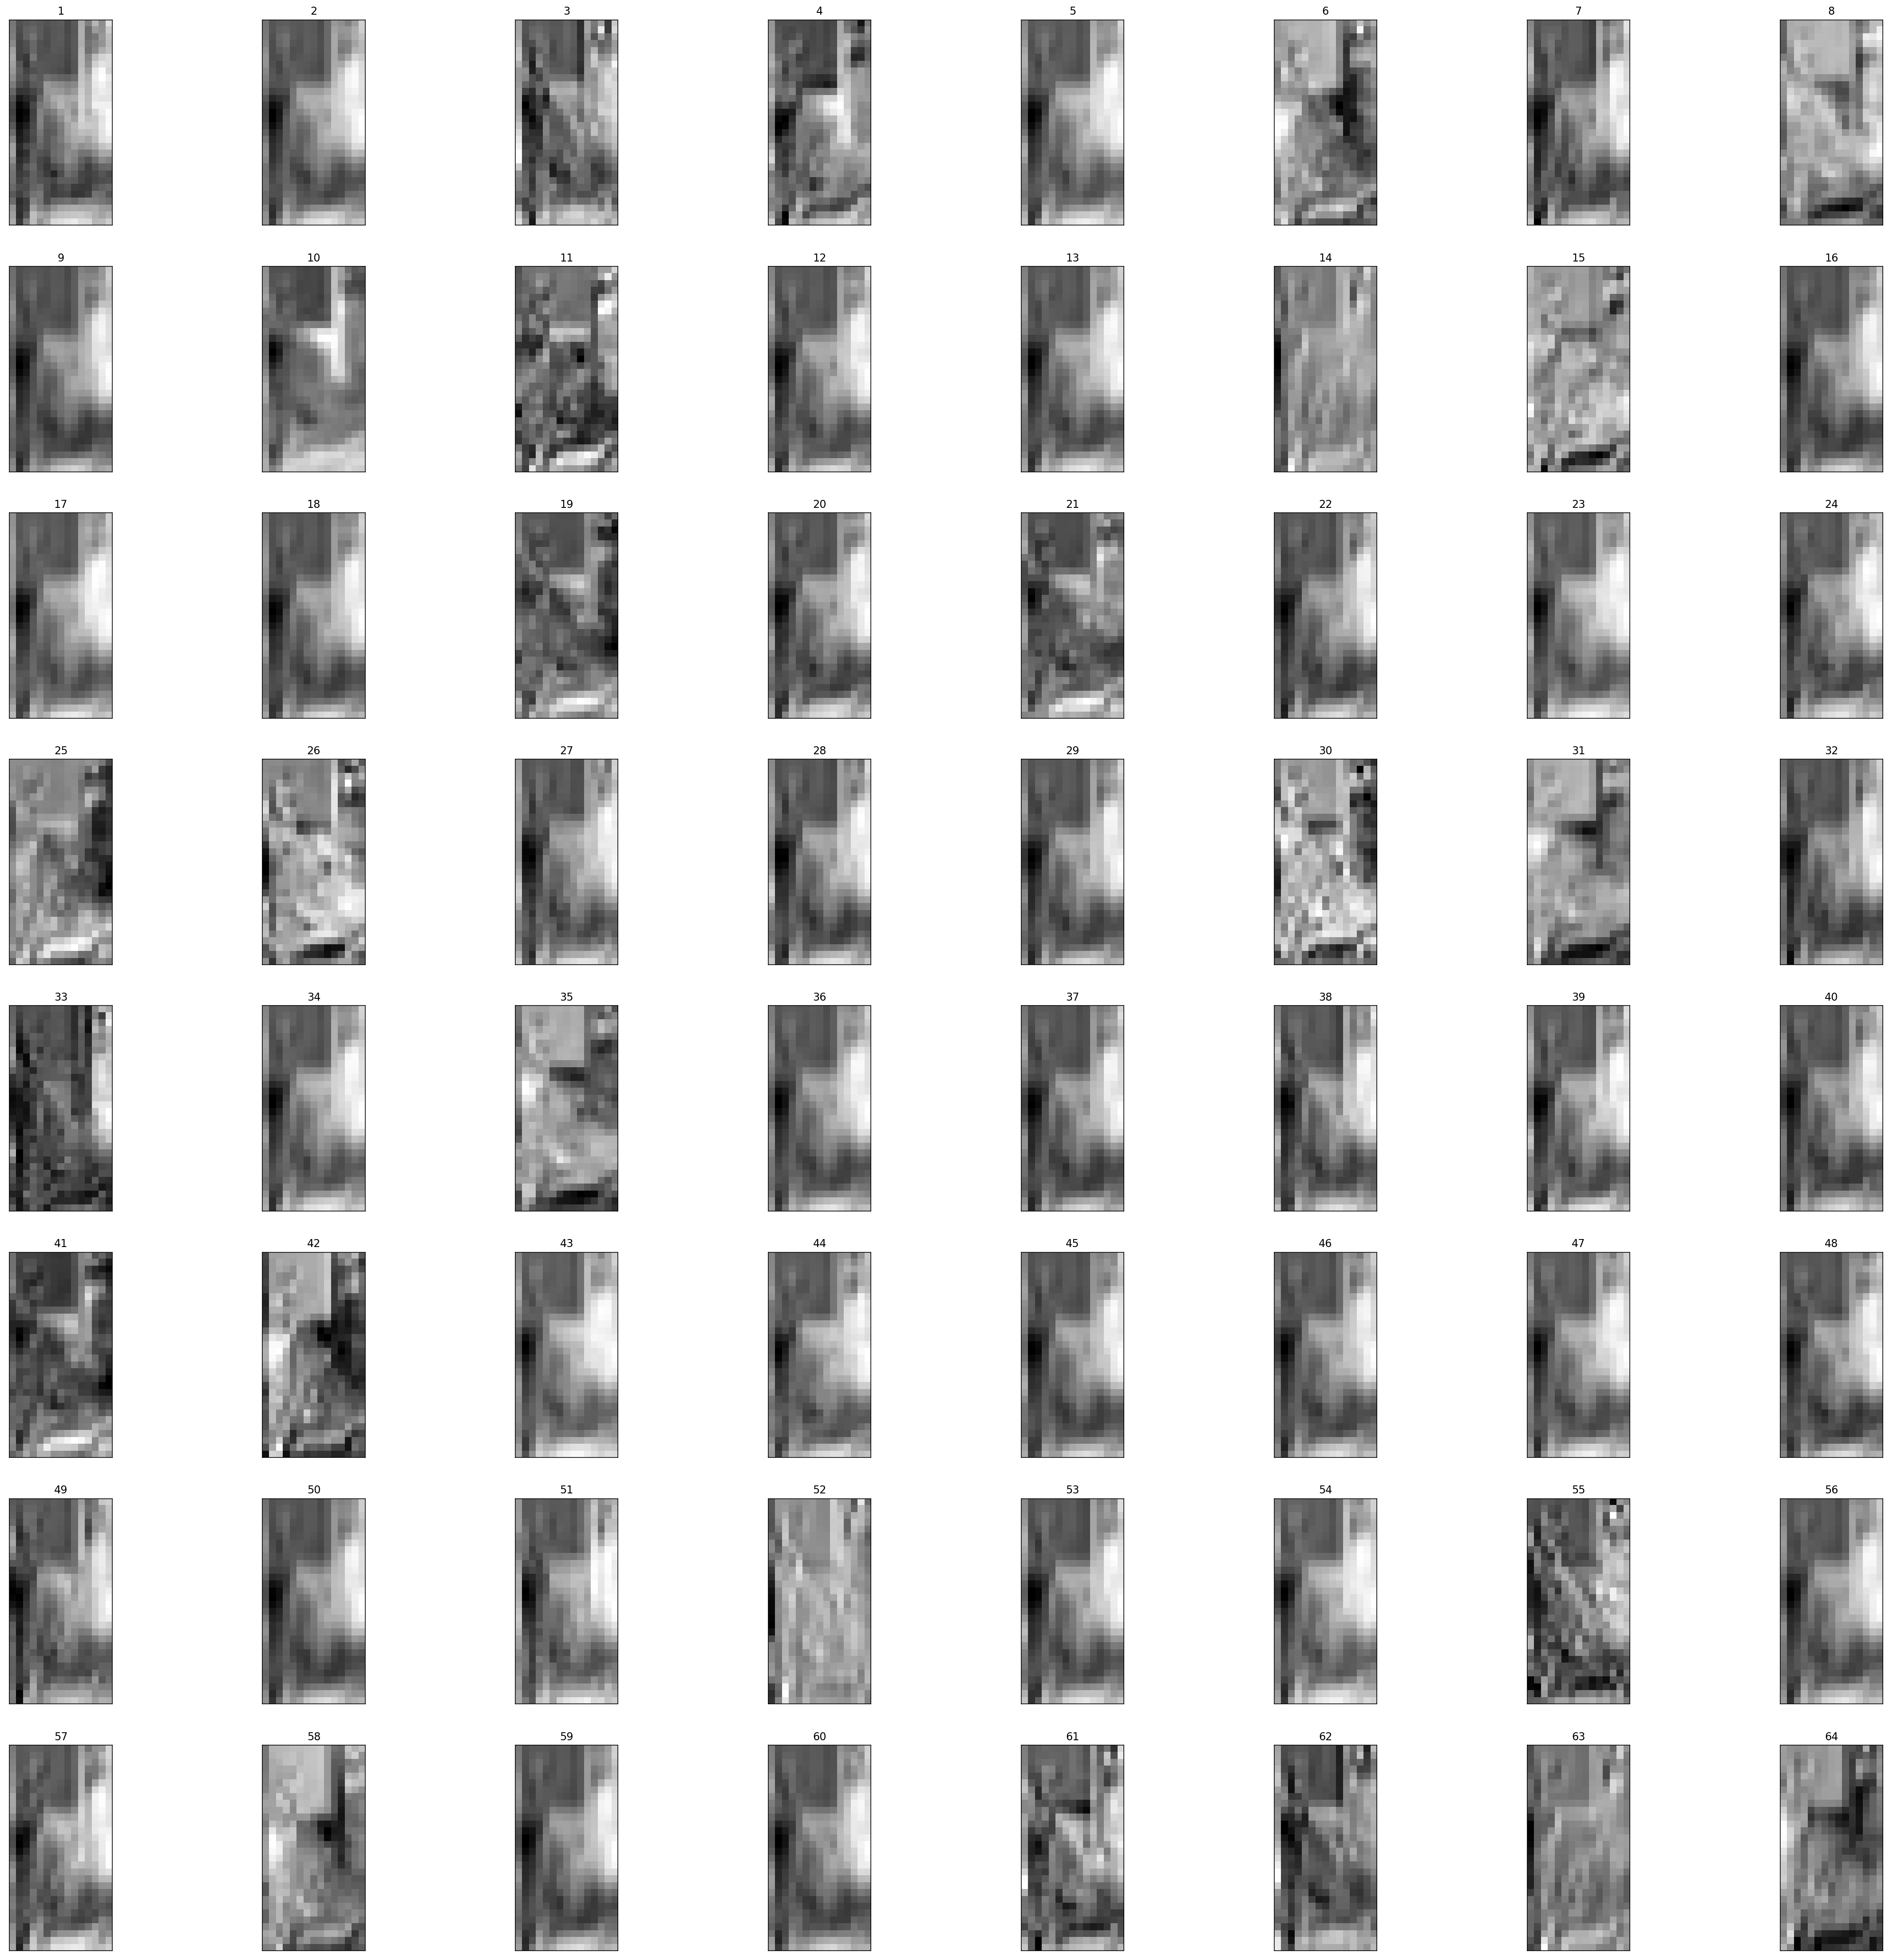

In [164]:
square = 8
ix = 1
plt.figure(figsize=(40,40))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(ix)
        # plot filter channel in grayscale
        plt.imshow(test0[:, :, ix-1], cmap='gray')
        ix += 1

In [55]:
a = 0
b = 1

mask_history[0,0,a,:,:,10]

TypeError: list indices must be integers or slices, not tuple

In [58]:
channel = 0
filters = 63
mask_history[0][0][channel,:,:,filters]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 1.],
       [0., 0., 0.],
       [1., 0., 0.]], dtype=float32)>

In [61]:
tf.reduce_sum(mask_history[0][0], axis=-1)

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[26., 20., 30.],
        [25., 18., 26.],
        [34., 22., 24.]],

       [[27., 32., 27.],
        [23., 25., 24.],
        [28., 24., 28.]],

       [[21., 26., 29.],
        [25., 33., 24.],
        [23., 26., 23.]]], dtype=float32)>

In [62]:
mask_history[0][0].shape

TensorShape([3, 3, 3, 64])

In [ ]:
mask_history[-1][2]

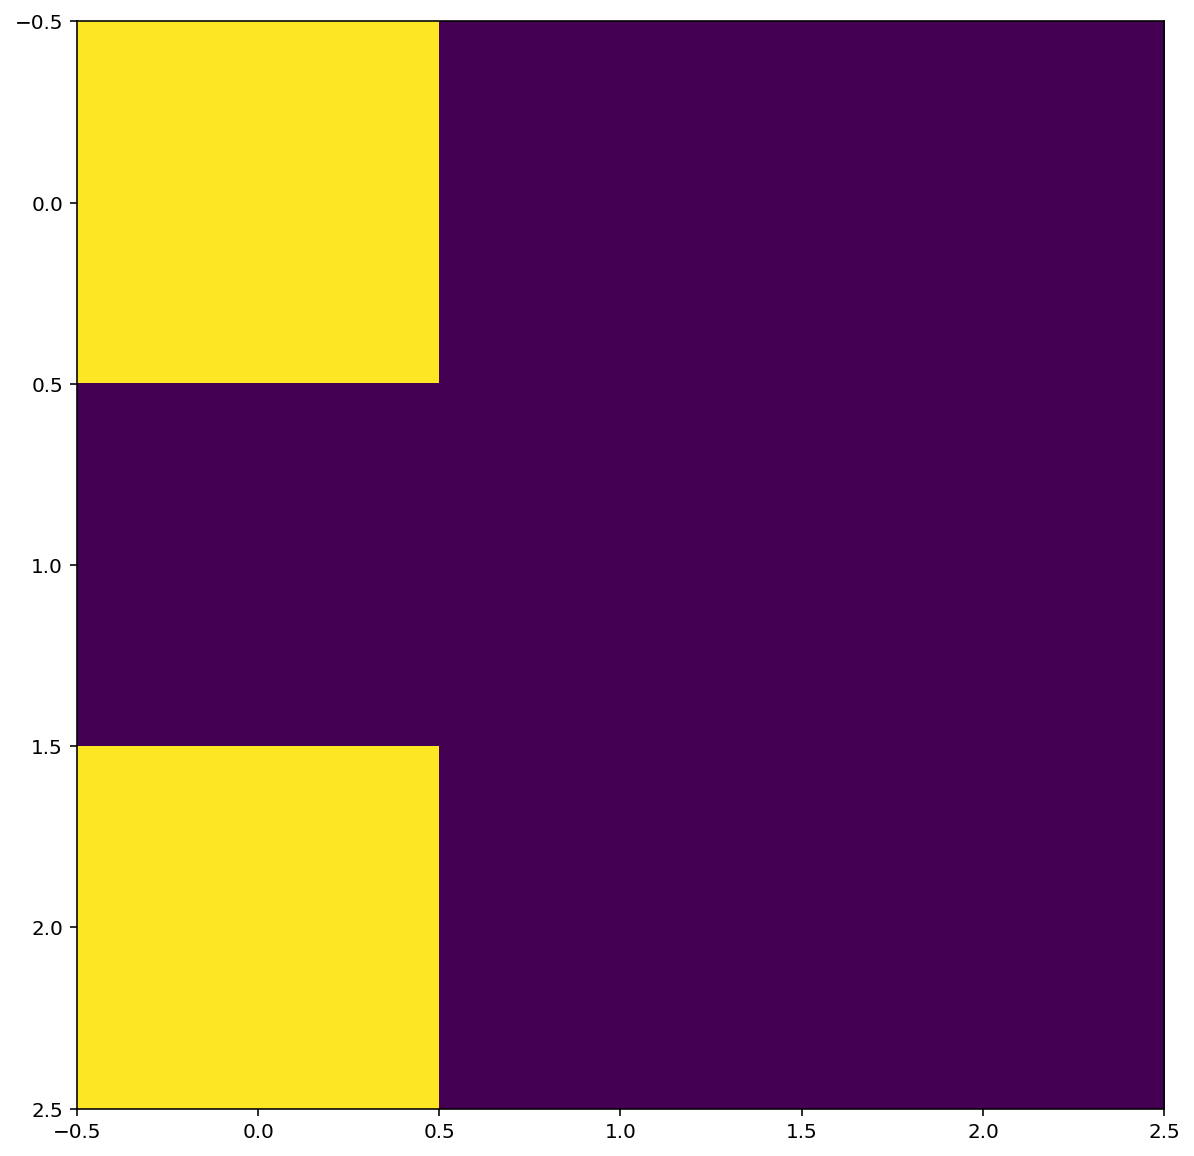

In [59]:
for channel in range(mask_history[0][0].shape[0]):
    for filters in range(mask_history[0][0].shape[-1]):
        plt.imshow(mask_history[0][0][channel,:,:,filters])

In [38]:
fcn_mask.layers[0].output

AttributeError: Layer conv_in has no inbound nodes.

In [297]:
x, layer_out = test(iter(ds_train_cif10).next()[0])

In [298]:
x

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[0.10327648, 0.06267342, 0.05225683, ..., 0.11587001, 0.14315353,
        0.15664676],
       [0.10937632, 0.06725454, 0.05979786, ..., 0.11515807, 0.16146076,
        0.16512643],
       [0.09326565, 0.08717821, 0.05079903, ..., 0.11886841, 0.14460754,
        0.1451218 ],
       ...,
       [0.08943109, 0.08698727, 0.05388276, ..., 0.13217412, 0.1264147 ,
        0.15845174],
       [0.08496665, 0.09950992, 0.04160346, ..., 0.12306143, 0.15474327,
        0.1632188 ],
       [0.09280412, 0.07776964, 0.04430648, ..., 0.12087853, 0.15411909,
        0.16789721]], dtype=float32)>

In [238]:
iter(ds_train_mnist).next()[0].shape

TensorShape([128, 28, 28, 1])

In [239]:
iter(ds_train_cif10).next()[0].shape

TensorShape([128, 32, 32, 3])

In [53]:
mc = MaskedConv2D(filters=64, kernel_size=3, input_shape=INPUT_SHAPE, use_bias=False)

In [54]:
mc.out_shape

(128, 26, 13, 64)

In [55]:
mc.get_mask(as_logit=True)

<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
          -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
           7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
          -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
          -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
          -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
          -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
          -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
           5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
          -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
           2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
          -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
          -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
           5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
          -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
          -9.8119

In [56]:
mc.set_weights

<bound method Layer.set_weights of <custom_nn.MaskedConv2D object at 0x7f446c048d90>>

In [57]:
3*3*1*64

576

In [58]:
mc.get_weights()

[array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
           -9.81193259e-02,  8.59625861e-02, -1.50663659e-01,
        

In [59]:
mc.get_weights()

[array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
           -9.81193259e-02,  8.59625861e-02, -1.50663659e-01,
        

In [60]:
mc.trainable_weights

[<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-4.30549085e-02, -9.87380147e-02,  8.25221166e-02,
           -5.88331930e-02, -3.56055461e-02,  2.41851844e-02,
            7.58366520e-03,  2.63399072e-02, -2.32688673e-02,
           -3.73841785e-02,  4.38836329e-02, -1.18723987e-02,
           -5.58252707e-02,  4.24915701e-02,  4.54991013e-02,
           -1.32199889e-02, -3.15771401e-02,  4.50575585e-03,
           -6.11123852e-02, -1.28976256e-02, -5.62764183e-02,
           -1.46060862e-04,  9.55470055e-02, -6.28002509e-02,
            5.77987023e-02,  1.61521230e-03,  4.45618900e-03,
           -1.70882940e-02,  1.01895267e-02,  6.32925890e-04,
            2.28676144e-02, -4.09628861e-02,  5.12597971e-02,
           -1.66248288e-02,  3.01541369e-02, -5.42329811e-02,
           -1.93796437e-02,  2.03722827e-02, -2.31280029e-02,
            5.82759641e-02, -1.18435398e-01,  5.78222536e-02,
           -3.14842276e-02,  6.86872527e-02,  3.39128301e-02,
 

In [61]:
mc.non_trainable_weights

[<tf.Variable 'Variable:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[ 0.06524039,  0.09070961, -0.03392106, -0.03798829,
            0.00492183,  0.01082622,  0.03999299,  0.02317412,
           -0.07749361,  0.00782654,  0.05761006, -0.05228462,
            0.01083441,  0.05870349,  0.07531562, -0.01971643,
           -0.02830264, -0.05419139,  0.08978821,  0.0461692 ,
           -0.01633086,  0.00431861, -0.01476197, -0.07867516,
           -0.0823853 , -0.08116492,  0.06094109,  0.04125399,
           -0.01254446,  0.01463621, -0.00706716, -0.03315062,
           -0.01356845,  0.00458248, -0.03665462, -0.03141736,
           -0.0371236 , -0.02497433, -0.01197346, -0.01053368,
           -0.04889293,  0.08293208,  0.02135742, -0.09017786,
            0.05083613, -0.02987114,  0.05883196, -0.00384949,
            0.03139707, -0.10422887, -0.01353978,  0.01707678,
           -0.0919968 , -0.01707014,  0.00794747, -0.0366854 ,
            0.01270528, -0.05380801, -0.04542204,

In [62]:
test = tf.cast(iter(ds_train_mnist).next()[0], tf.float32)

In [63]:
test.shape

TensorShape([128, 28, 28, 1])

In [64]:
mc(test)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [252]:
mc.out_shape

(128, 30, 15, 64)

In [253]:
test_maxpool = MaxPool2DExt(input_shape = mc.out_shape, pool_size=(2, 2), strides=None, padding='valid', data_format=None)

In [254]:
test_maxpool.out_shape

(128, 15, 7, 64)

In [255]:
MaxPool2DExt(input_shape = mc.out_shape, pool_size=(2, 2), strides=None, padding='valid', data_format=None
)(mc(test))

Shape mask:  (3, 3, 3, 64)
kernel shape:  (3, 3, 3, 64)
input type:  <dtype: 'float32'>
kernel type:  <dtype: 'float32'>


<tf.Tensor: shape=(128, 15, 7, 64), dtype=float32, numpy=
array([[[[-1.96953103e-01,  4.57083294e-03, -4.06591818e-02, ...,
           1.24540702e-01,  1.31059168e-02, -2.21784711e-02],
         [-1.76682308e-01,  1.12280967e-02, -4.10067551e-02, ...,
           1.21692300e-01,  1.97234582e-02, -3.07511184e-02],
         [-1.50002584e-01,  2.45225411e-02, -3.70416790e-02, ...,
           1.82082012e-01,  4.48386930e-02, -1.16773844e-02],
         ...,
         [-1.29290432e-01,  1.41991386e-02, -1.97706446e-02, ...,
           9.98345837e-02,  3.36731412e-02, -2.21954454e-02],
         [-1.14069469e-01,  1.04040215e-02, -2.69249752e-02, ...,
           8.74431729e-02,  1.31684160e-02, -3.14040221e-02],
         [-7.02040419e-02,  8.39326810e-03, -8.12536012e-03, ...,
           6.75963312e-02,  2.47040242e-02, -1.52848270e-02]],

        [[-1.69056758e-01,  8.25486425e-03, -3.15850228e-02, ...,
           9.88578498e-02,  2.46816091e-02, -4.65485938e-02],
         [-1.90339148e-01,  3.

In [82]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [256]:
a = (4,3,2,1)

In [257]:
import tensorflow as tf
tf.math.reduce_prod(a)

<tf.Tensor: shape=(), dtype=int32, numpy=24>